In [1]:
import os#
from pathlib import Path#

import pandas as pd
import torch


import numpy as np
from stk_search.utils.config_utils import read_config, save_config
from stk_search.utils import update_datasets
import importlib
importlib.reload(update_datasets)
os.makedirs('search_experiment/search_exp_database', exist_ok=True)

In [2]:
# load Search space and check conditions
import pickle
search_space_loc = "search_space/search_space_test.pkl"


SP = pickle.load(open(search_space_loc, 'rb'))
SP.update()
print(SP.syntax)
print(SP.conditions_list)
print(f"size of the search space is : {SP.get_space_size():.2e}")
SP.df_precursors.head()

[0, 1, 2, 3, 4, 5]
[[], [], [], [], [], []]
size of the search space is : 0.00e+00


,electron affinity (eV),homo lumo_gap (eV),ionisation potential (eV),total energy (au),HOMO-LUMO GAP (eV),ES1,fosc1,InChIKey,mol_opt,Atom_num
0,3.0685,0.095166,9.1140,-56.555859,1.672081,3.787,0.0003,GVYASUPVXDSGHN-UQCOIBPSSA-N,<rdkit.Chem.rdchem.Mol object at 0x7c3c1be77450>,22
1,2.8466,0.038435,9.3325,-56.536670,2.258122,3.514,0.0016,HNRHIGPDSSXEJA-FARCUNLSSA-N,<rdkit.Chem.rdchem.Mol object at 0x7c3c1be77400>,22
2,2.9365,0.072094,9.2252,-56.533763,2.009171,3.414,0.0003,SNMJIXVGAOBXCS-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7c3c1be774a0>,22
3,2.5901,0.064465,8.9842,-48.098467,2.153852,3.364,0.0008,LWMBLJLODRWDDF-NYYWCZLTSA-N,<rdkit.Chem.rdchem.Mol object at 0x7c3c1be774f0>,22
4,2.5596,0.076792,8.8405,-48.091982,1.967541,3.342,0.0004,BJFIUKSBVAJFOJ-WTKPLQERSA-N,<rdkit.Chem.rdchem.Mol object at 0x7c3c1be77540>,22


In [3]:
from stk_search.Objective_function import  Look_up_table
df_total_path = "data_example/Molecule_database/30K_benchmark_150524.csv"
df_total = pd.read_csv(df_total_path)
oligomer_size = 6
target_name = 'target'
aim = 'maximise'
df_total['target'] = (
        -np.abs(df_total["ES1"] - 3)
        - np.abs(df_total["ionisation potential (eV)"] - 5.5)
        + np.log10(df_total["fosc1"])
    )
df_total.to_csv(df_total_path, index=False)
# define the evaluation function
objective_function = Look_up_table(
            df_total, oligomer_size, target_name=target_name, aim=aim
        )

In [4]:
# test evaluation function
molecule_id = 0
molecule_properties = SP.check_df_for_element_from_sp(df_total).iloc[[molecule_id]]
print(molecule_properties['InChIKey'])
molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]]
objective_function.evaluate_element(molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]])

0    CLUOOVKTWZALSH-UHFFFAOYSA-N
Name: InChIKey, dtype: object


(-2.5070288713583553, 'CLUOOVKTWZALSH-UHFFFAOYSA-N')

In [5]:
# initialise search algorithm 
from stk_search.Search_algorithm import BayesianOptimisation
from stk_search.Search_algorithm import Ea_surrogate

from stk_search.Search_algorithm.Search_algorithm import evolution_algorithm
from stk_search.Search_algorithm import Search_algorithm
importlib.reload(Search_algorithm)
importlib.reload(Ea_surrogate)
importlib.reload(BayesianOptimisation)
which_acquisition = 'EI'
lim_counter = 10
BO_learned = BayesianOptimisation.BayesianOptimisation(which_acquisition=which_acquisition, lim_counter=lim_counter)
EA = Search_algorithm.evolution_algorithm()
SUEA = Ea_surrogate.Ea_surrogate()
BO_Mord = BayesianOptimisation.BayesianOptimisation(which_acquisition=which_acquisition, lim_counter=lim_counter)

In [65]:
# load the representation and the model 
from stk_search.Search_algorithm import Ea_surrogate

from stk_search.Representation import  Representation_poly_3d
import importlib
importlib.reload(Representation_poly_3d)
from stk_search.geom3d import pl_model
import torch.nn.functional as Functional
from stk_search.geom3d import train_models
from stk_search.Representation import  Representation_poly_3d

import importlib
importlib.reload(Representation_poly_3d)
importlib.reload(Ea_surrogate)


#config_dir = "/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240430/SchNet/splitrand-nummol68864/Emb_dim_12"
config_dir = "data_example/representation_learning/splitrand-nummol20000/"
config, min_val_loss = train_models.get_best_embedding_model(config_dir)

SUEA = Ea_surrogate.Ea_surrogate()
SUEA.config_dir = config_dir
SUEA.load_representation_model()
BO_learned.config_dir = config_dir
BO_learned.load_representation_model()


Model loaded:  SchNet
Model loaded:  SchNet


(<stk_search.Representation.Representation_poly_3d.Representation_poly_3d at 0x7c3c18641490>,
 Pymodel_new(
   (molecule_3D_repr): SchNet(hidden_channels=128, num_filters=128, num_interactions=8, num_gaussians=51, cutoff=6)
   (graph_pred_linear): Linear(in_features=128, out_features=1, bias=True)
   (transform_to_opt): Linear(in_features=128, out_features=128, bias=True)
 ))

In [7]:
# initialise the representation of the molecules used
# here we use the dataframe of the precursors that has PCA of desrciprtors calculated using mordred
from stk_search.Representation import (
    Representation_from_fragment,
    Representation_3d_from_fragment,
)

df_representation_path = "data_example/precursor/df_mordred_24072024.pkl"
df_representation = pd.read_pickle(df_representation_path)
df_representation.dropna(axis=1, inplace=True)
# check if the representation dataframe contains all the elements in teh search space
print(
    "number of element not in the representation dataframe ",
    -(SP.df_precursors["InChIKey"].isin(df_representation["InChIKey"]).sum()
    - SP.df_precursors.shape[0]),
)
if -(SP.df_precursors["InChIKey"].isin(df_representation["InChIKey"]).sum() - SP.df_precursors.shape[0]) > 0:
    SP.df_precursors = SP.df_precursors[SP.df_precursors["InChIKey"].isin(df_representation["InChIKey"])]
    with open(search_space_loc, "wb") as f:
        pickle.dump(SP, f)
frag_properties = df_representation.select_dtypes(include=[np.number]).columns
print(frag_properties)
BO_Mord.Representation = Representation_from_fragment.Representation_from_fragment(
    df_representation, frag_properties
)


number of element not in the representation dataframe  0
Index(['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7',
       'PCA_8', 'PCA_9'],
      dtype='object')


In [66]:
# test representation
import swifter
molecule_id = 0
molecule_properties = SP.check_df_for_element_from_sp(df_total).iloc[[molecule_id]]
print(molecule_properties['InChIKey'])
molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]]
X_rpr = SUEA.Representation.generate_repr(molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]])
print(X_rpr)
X_rpr = BO_learned.Representation.generate_repr(molecule_properties[[f'InChIKey_{x}' for x in range(oligomer_size)]])
print(X_rpr)

0    CLUOOVKTWZALSH-UHFFFAOYSA-N
Name: InChIKey, dtype: object


Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 0.1263,  0.4300,  0.6014, -0.0017,  0.1554,  0.3626, -0.0955, -0.3296,
          0.2915,  0.1070, -0.2236, -0.2313, -0.1166,  0.1053, -0.3550,  0.1256,
         -0.3499,  0.0347, -0.5033, -0.0738,  0.0305,  0.2019,  0.2527,  0.1323,
          0.1438,  0.2728, -0.3899, -0.4819,  0.2105, -0.4013,  0.1972, -0.4838,
          0.0880,  0.2719, -0.1887,  0.2819,  0.1808,  0.2708, -0.2144,  0.1229,
          0.3219, -0.0189,  0.4707, -0.1135,  0.5042, -0.3085, -0.0295, -0.1317,
          0.1006,  0.4829, -0.1968, -0.0867, -0.0867, -0.0625, -0.1086, -0.2517,
         -0.4695, -0.1857, -0.5688,  0.5749, -0.2925,  0.4684, -0.4030, -0.0425,
          0.0295,  0.4462, -0.2801,  0.1418, -0.2735,  0.3249,  0.4434, -0.1269,
         -0.0185,  0.2498, -0.2160, -0.2722,  0.0087, -0.0853, -0.1108,  0.1225,
         -0.0586, -0.0576, -0.6213,  0.1998,  0.4126, -0.0173,  0.2789,  0.0935,
          0.2983,  0.1193, -0.0322,  0.2770,  0.0368, -0.0855,  0.2541, -0.0109,
          0.2549, -0.4222, -

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 0.1263,  0.4300,  0.6014, -0.0017,  0.1554,  0.3626, -0.0955, -0.3296,
          0.2915,  0.1070, -0.2236, -0.2313, -0.1166,  0.1053, -0.3550,  0.1256,
         -0.3499,  0.0347, -0.5033, -0.0738,  0.0305,  0.2019,  0.2527,  0.1323,
          0.1438,  0.2728, -0.3899, -0.4819,  0.2105, -0.4013,  0.1972, -0.4838,
          0.0880,  0.2719, -0.1887,  0.2819,  0.1808,  0.2708, -0.2144,  0.1229,
          0.3219, -0.0189,  0.4707, -0.1135,  0.5042, -0.3085, -0.0295, -0.1317,
          0.1006,  0.4829, -0.1968, -0.0867, -0.0867, -0.0625, -0.1086, -0.2517,
         -0.4695, -0.1857, -0.5688,  0.5749, -0.2925,  0.4684, -0.4030, -0.0425,
          0.0295,  0.4462, -0.2801,  0.1418, -0.2735,  0.3249,  0.4434, -0.1269,
         -0.0185,  0.2498, -0.2160, -0.2722,  0.0087, -0.0853, -0.1108,  0.1225,
         -0.0586, -0.0576, -0.6213,  0.1998,  0.4126, -0.0173,  0.2789,  0.0935,
          0.2983,  0.1193, -0.0322,  0.2770,  0.0368, -0.0855,  0.2541, -0.0109,
          0.2549, -0.4222, -

In [67]:
from stk_search import SearchExp

importlib.reload(SearchExp)


# set experiment conditions
def define_and_run_search(
    search_algorithm=EA,
    num_elem_initialisation=50,
    number_of_iterations=100,
    verbose=True,
    case_name="test",
):

    S_exp = SearchExp.SearchExp(
        SP,
        search_algorithm,
        objective_function,
        number_of_iterations,
        verbose=verbose,
    )
    benchmark = True
    S_exp.output_folder = (
        f"output/search_experiment/{oligomer_size}_frag/" + case_name
    )
    S_exp.num_elem_initialisation = num_elem_initialisation
    S_exp.benchmark = benchmark
    S_exp.df_total = df_total
    # Save search inputs
    import json
    import subprocess

    def save_run_search_inputs(inputs, save_path="run_search_new_inputs.json"):
        # Get the current git version
        git_version = (
            subprocess.check_output(["git", "rev-parse", "HEAD"])
            .strip()
            .decode("utf-8")
        )

        # Add the git version to the inputs
        inputs["git_version"] = git_version

        # Save the inputs to a file
        with open(save_path, "w") as f:
            json.dump(inputs, f)

        print("Inputs saved.")

    input_json = {}
    input_json["search_space_loc"] = search_space_loc
    input_json["search_algorithm"] = search_algorithm.name
    input_json["objective_function"] = objective_function.__str__()
    input_json["number_of_iterations"] = number_of_iterations
    input_json["verbose"] = verbose
    input_json["num_elem_initialisation"] = num_elem_initialisation
    input_json["benchmark"] = benchmark
    input_json["df_total"] = df_total_path
    input_json["df_representation"] = df_representation_path
    if 'Representation' in search_algorithm.__dict__.keys(): 
        input_json["representation"] = search_algorithm.Representation.name
    else:
        input_json["representation"] = None
    input_json["frag_properties"] = list(frag_properties)
    input_json["which_acquisition"] = which_acquisition
    input_json["run_search_name"] = S_exp.search_exp_name
    input_json["search_output_folder"] = S_exp.output_folder
    input_json["date"] = S_exp.date
    input_json["oligomer_size"] = oligomer_size
    input_json["config_dir"] = config_dir
    input_json["case_name"] = case_name
    save_path = f"output/search_experiment/search_exp_database/{S_exp.search_exp_name}.json"
    os.makedirs(
        "output/search_experiment/search_exp_database", exist_ok=True
    )
    save_run_search_inputs(input_json, save_path)
    S_exp.run_seach()
    return max(S_exp.ids_acquired)

In [68]:
for _ in range(10):
    define_and_run_search(search_algorithm=EA,case_name="EA")

Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.
Inputs saved.


In [70]:
for _ in range(10):
    define_and_run_search(search_algorithm=SUEA,case_name="SUEA")

Inputs saved.


Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/38 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/87 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/139 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/124 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/168 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/67 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/152 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/163 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/120 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/158 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/132 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/120 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/132 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/140 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/36 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/18 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/158 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/131 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/149 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/114 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/105 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/178 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/119 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/124 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/133 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/37 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/148 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/138 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/148 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/164 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/153 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/120 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/147 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/133 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/119 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/119 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/113 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/128 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/131 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/143 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/158 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/140 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/136 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/138 [00:00<?, ?it/s]

Inputs saved.


Pandas Apply:   0%|          | 0/94 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/80 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/87 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/108 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/90 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/167 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/66 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/196 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/197 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/133 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/152 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/166 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/178 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/169 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/49 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/162 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/223 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/180 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/201 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/169 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/190 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/265 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/237 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/196 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/185 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/216 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/38 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/190 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/213 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/210 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/148 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/247 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/216 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/223 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/240 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/213 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/197 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/248 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/211 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/210 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/259 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/239 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/149 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/194 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/211 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/241 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/179 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/250 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/230 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/212 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/219 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/194 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/158 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/154 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/214 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/195 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/236 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/240 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/214 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/185 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/206 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/195 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/201 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/250 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/202 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/197 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/179 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/195 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/220 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/258 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/268 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/213 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/234 [00:00<?, ?it/s]

Inputs saved.


Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/108 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/151 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/151 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/151 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/164 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/168 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/154 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/190 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/173 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/166 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/168 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/180 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/195 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/172 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/172 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/168 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/226 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/175 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/231 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/163 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/175 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/253 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/207 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/203 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/249 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/196 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/203 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/166 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/169 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/157 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/203 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/166 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/172 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/177 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/190 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/163 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/205 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/179 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/163 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/239 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/64 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/207 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/203 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/201 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/234 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/205 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/273 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/214 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/164 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/205 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/154 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/164 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/168 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/173 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/202 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/175 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/304 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/166 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/164 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/239 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/195 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/202 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Inputs saved.


Pandas Apply:   0%|          | 0/81 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/171 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/157 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/143 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/241 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/255 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/197 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/175 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/168 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/177 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/222 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/61 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/162 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/221 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/334 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/164 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/336 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/338 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/158 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/217 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/158 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/190 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/252 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/240 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/255 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/166 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/176 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/205 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/243 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/186 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/220 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/176 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/245 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/206 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/201 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/243 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/190 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/171 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/176 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/236 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/322 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/211 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/169 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/194 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/167 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/285 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/176 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/173 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/236 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/197 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/163 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/306 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/338 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/310 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/164 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/176 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/163 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/157 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/179 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/202 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/210 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189 [00:00<?, ?it/s]

Inputs saved.


Pandas Apply:   0%|          | 0/91 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/26 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/22 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/140 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/23 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/172 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/31 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/136 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/126 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/128 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/114 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/131 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/97 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/90 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/105 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/140 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/124 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/126 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/128 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/152 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/105 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/133 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/108 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/124 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/105 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/87 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/133 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/97 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/95 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/88 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/77 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/90 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/95 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/91 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Inputs saved.


Pandas Apply:   0%|          | 0/90 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/35 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/90 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/151 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/94 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/89 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/79 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/243 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/105 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/85 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/94 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/86 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/86 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/94 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/96 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/95 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/94 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/119 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/83 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/128 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/138 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/183 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/119 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/114 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/138 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/132 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/114 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/108 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/113 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/132 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/133 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/132 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/114 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/126 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/120 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/22 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/141 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/124 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

KeyError: '[143] not in index'

In [76]:
for _ in range(5):
    define_and_run_search(search_algorithm=BO_learned,case_name="BO_learned")

Inputs saved.


Pandas Apply:   0%|          | 0/50 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/50 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/87 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/37 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/114 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/27 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/135 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/140 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/183 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/43 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/186 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/196 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/203 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/224 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/51 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/67 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/79 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/138 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/139 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/148 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/148 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/151 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/162 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/172 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/173 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/52 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/64 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/85 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/86 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/95 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/113 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/154 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/179 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/25 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/77 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/34 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/132 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/139 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/153 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/154 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/162 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/54 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/59 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/105 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/167 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/56 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/167 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/206 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/228 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/242 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/244 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/298 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/51 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/55 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/92 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/96 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/119 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/126 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/141 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/148 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/285 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/302 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/302 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/324 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/18 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/326 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/413 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/82 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/420 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/468 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/45 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/474 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/511 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/517 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/541 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/542 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/545 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/547 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/555 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/555 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/584 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/56 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/124 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/128 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/151 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/158 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/190 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/267 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/66 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/268 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/275 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/284 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/418 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/57 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/64 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/144 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/58 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/215 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/225 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/227 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/271 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/286 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/308 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/22 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/371 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/58 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/377 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/390 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/400 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/402 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/403 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/438 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/438 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/445 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/449 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/449 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/523 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/65 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/59 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/96 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/113 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/140 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/166 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/166 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/171 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/236 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/60 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/219 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/252 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/295 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/304 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/310 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/311 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/320 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/327 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/330 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/398 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/405 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/407 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/61 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/77 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/88 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/128 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/162 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/197 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/62 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/96 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/108 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/255 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/272 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/63 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/96 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/113 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/70 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/229 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/234 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/237 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/249 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/262 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/292 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/298 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/309 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/330 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/330 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/336 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/343 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/604 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/140 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/617 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/633 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/704 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/68 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/708 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/843 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/845 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/846 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/849 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/851 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/866 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/873 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/884 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/886 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/64 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/151 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/159 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/205 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/220 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/220 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/230 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/247 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/253 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/259 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/266 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/273 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/283 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/294 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/313 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/322 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/341 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/346 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/65 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/85 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/160 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/171 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/176 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/181 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/211 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/245 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/255 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/66 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/85 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/98 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/125 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/131 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/141 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/141 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/145 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/176 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/179 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/67 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/96 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/108 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/123 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/143 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/158 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/194 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/203 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/217 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/217 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/68 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/83 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/97 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/136 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/138 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/144 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/154 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/69 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/80 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/134 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/156 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/173 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/201 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/202 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/207 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/70 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/131 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/149 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/171 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/183 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/239 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/239 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/292 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/322 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/467 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/471 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/472 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/477 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/477 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/494 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/498 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/71 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/108 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/121 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/196 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/201 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/202 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/213 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/220 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/239 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/244 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/310 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/72 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/104 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/117 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/169 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/257 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/275 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/282 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/335 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/401 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/407 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/73 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/93 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/115 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/252 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/262 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/274 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/282 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/291 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/299 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/322 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/325 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/328 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/329 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/74 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/128 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/246 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/250 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/251 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/261 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/270 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/270 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/277 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/412 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/420 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/448 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/75 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/97 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/102 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/114 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/151 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/190 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/197 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/221 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/257 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/265 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/76 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/152 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/154 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/290 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/293 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/304 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/309 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/313 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/326 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/338 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/341 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/353 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/359 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/360 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/77 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/108 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/128 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/136 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/157 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/196 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/247 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/270 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/405 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/407 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/418 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/438 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/124 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/132 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/169 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/172 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/173 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/195 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/235 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/245 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/247 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/247 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/273 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/79 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/148 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/148 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/163 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/175 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/175 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/182 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/186 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/80 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/124 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/138 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/138 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/206 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/212 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/212 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/222 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/230 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/243 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/252 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/256 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/256 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/392 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/399 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/402 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/418 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/427 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/431 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/435 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/467 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/467 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/467 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/467 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/546 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/118 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/130 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/155 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/171 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/185 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/195 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/229 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/234 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/234 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/234 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/250 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/251 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/257 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/257 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/265 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/280 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/335 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/340 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/346 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/349 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/380 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/380 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/381 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/383 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/387 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/394 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/82 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/125 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/240 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/242 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/249 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/581 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/60 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/745 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/745 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/789 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/794 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/795 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/798 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/803 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/809 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/830 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/855 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/25 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/863 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/83 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/153 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/153 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/161 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/197 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/202 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/205 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/207 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/209 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/226 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/226 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/226 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/230 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/253 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/119 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/152 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/172 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/262 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/272 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/277 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/281 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/281 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/281 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/85 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/143 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/187 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/188 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/194 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/194 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/208 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/86 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/173 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/174 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/201 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/203 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/204 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/207 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/224 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/224 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/239 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/242 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/254 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/87 [00:00<?, ?it/s]

In [ ]:
for _ in range(5):
    define_and_run_search(search_algorithm=BO_Mord,case_name="BO_Mord")

Inputs saved.


/home/mohammed/anaconda3/envs/stk_search2/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/mohammed/anaconda3/envs/stk_search2/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/home/mohammed/anaconda3/envs/stk_search2/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/mohammed/anaconda3/envs/stk_search2/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/mohammed/anaconda3/envs/stk_search2/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/mohammed/anaconda3/

149

# load results and plot some metrics

In [71]:

import glob
import pickle
import json
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row['search_exp_file'], "rb")))
    return search_list
save_path = f"output/search_experiment/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            list_json.append(json.load(f))
        f.close()
    except: 
        print('error oppening',json_file)
df = pd.DataFrame(list_json)
df['search_exp_file'] = df['search_output_folder']+"/"+df['date']+"/results_"+df['run_search_name']+'.pkl'
print(df.shape)
df_all = df.copy()
df_all.head()


(32, 20)


,search_space_loc,search_algorithm,objective_function,number_of_iterations,verbose,num_elem_initialisation,benchmark,df_total,df_representation,representation,frag_properties,which_acquisition,run_search_name,search_output_folder,date,oligomer_size,config_dir,case_name,git_version,search_exp_file
0,search_space/search_space_test.pkl,Bayesian_Optimisation,<stk_search.Objective_function.Look_up_table o...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,Representation_poly_3d,"[PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...",EI,3246270be1a3453090bddfad891001a6,output/search_experiment/6_frag/BO_learned,20240802,6,data_example/representation_learning/splitrand...,BO_learned,ab9492b1a0b17402e63f34abb4f1a5529ff4196c,output/search_experiment/6_frag/BO_learned/202...
1,search_space/search_space_test.pkl,Evolution_algorithm,<stk_search.Objective_function.Look_up_table o...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,None,"[PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...",EI,f8114b25c4834dfebbf397fa962b786c,output/search_experiment/6_frag/EA,20240802,6,data_example/representation_learning/splitrand...,EA,ab9492b1a0b17402e63f34abb4f1a5529ff4196c,output/search_experiment/6_frag/EA/20240802/re...
2,search_space/search_space_test.pkl,Evolution_algorithm,<stk_search.Objective_function.Look_up_table o...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,None,"[PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...",EI,396f0f5c169545e5b7e0fa1b9312fe39,output/search_experiment/6_frag/EA,20240802,6,data_example/representation_learning/splitrand...,EA,ab9492b1a0b17402e63f34abb4f1a5529ff4196c,output/search_experiment/6_frag/EA/20240802/re...
3,search_space/search_space_test.pkl,Evolution_algorithm,<stk_search.Objective_function.Look_up_table o...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,None,"[PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...",EI,ff78b9b8c82540a6b4b543b68ab138b6,output/search_experiment/6_frag/EA,20240802,6,data_example/representation_learning/splitrand...,EA,ab9492b1a0b17402e63f34abb4f1a5529ff4196c,output/search_experiment/6_frag/EA/20240802/re...
4,search_space/search_space_test.pkl,Surrogate_EA,<stk_search.Objective_function.Look_up_table o...,100,True,50,True,data_example/Molecule_database/30K_benchmark_1...,data_example/precursor/df_mordred_24072024.pkl,Representation_poly_3d,"[PCA_0, PCA_1, PCA_2, PCA_3, PCA_4, PCA_5, PCA...",EI,c8b89fe2b3414f7a8ca818cc90b2c95b,output/search_experiment/6_frag/SUEA,20240802,6,data_example/representation_learning/splitrand...,SUEA,ab9492b1a0b17402e63f34abb4f1a5529ff4196c,output/search_experiment/6_frag/SUEA/20240802/...


In [72]:
num_iteration = 20
num_elem_initialisation = 50
oligomer_size = 6 
#df_filtered = df_all[df_all['num_iteration']==num_iteration]
#df_filtered = df_filtered[df_filtered['num_elem_initialisation']==num_elem_initialisation]
df_filtered = df_all[df_all['oligomer_size']==oligomer_size]
print(df_filtered.shape)
df_list = df_filtered.groupby(['which_acquisition','config_dir','search_algorithm','case_name'])
print(len(df_list))
df_list.describe()

(32, 20)
4


number_of_iterations  \
                                                                                                                     count   
which_acquisition config_dir                                         search_algorithm      case_name                         
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord                     2.0   
                                                                                           BO_learned                  3.0   
                                                                     Evolution_algorithm   EA                         16.0   
                                                                     Surrogate_EA          SUEA                       11.0   

                                                                                                                  \
                                                                                                            mean   
which_acquisition config_dir                                         search_algorithm      case_name               
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord     60.000000   
                                                                                           BO_learned  73.333333   
                                                                     Evolution_algorithm   EA          95.000000   
                                                                     Surrogate_EA          SUEA        92.727273   

                                                                                                                  \
                                                                                                             std   
which_acquisition config_dir                                         search_algorithm      case_name               
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord     56.568542   
                                                                                           BO_learned  46.188022   
                                                                     Evolution_algorithm   EA          20.000000   
                                                                     Surrogate_EA          SUEA        24.120908   

                                                                                                             \
                                                                                                        min   
which_acquisition config_dir                                         search_algorithm      case_name          
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord     20.0   
                                                                                           BO_learned  20.0   
                                                                     Evolution_algorithm   EA          20.0   
                                                                     Surrogate_EA          SUEA        20.0   

                                                                                                              \
                                                                                                         25%   
which_acquisition config_dir                                         search_algorithm      case_name           
EI                data_example/representation_learning/splitrand-... Bayesian_Optimisation BO_Mord      40.0   
                                                                                           BO_learned   60.0   
                                                                     Evolution_algorithm   EA          100.0   
                                                                     Surrogate_EA          SUEA        100.0   

                              

In [73]:
import pandas as pd
def join_name(x):
    return '_'.join(x)

def load_search_list(df,min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row['max_num_eval']:
            search_list.append(pd.read_pickle(row['search_exp_file']))
    return search_list
def get_results_length(x):
    try:
        return len(pd.read_pickle(x)['fitness_acquired'])
    except Exception as e:
        #print(e)
        return 0
results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 100
for name , df in df_list:
    if len(df) != 0: 
        df['max_num_eval']=df['search_exp_file'].apply(lambda x: get_results_length(x))
        key = join_name(name)
        df['key'] = key
        if df['max_num_eval'].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df,min_num_iteration)
            num_searches_with_min[key] = (len(results_dict[key]), df['df_total'].values[0])
df_summary_1 = pd.DataFrame.from_dict(num_searches_with_min, orient='index',columns=['number of explorations with min iterations','df_path'])
#df_summary = df_summary.merge(df_summary_1, left_index=True, right_index=True)
df_summary_1['key'] = df_summary_1.index    
df_summary_1['case_name'] = df_summary_1['key'].apply(lambda x: x.split('_')[-2]+'_'+x.split('_')[-1])
df_summary_1['num_mol_training'] = df_summary_1['key'].apply(lambda x: x.split('nummol')[-1])
df_summary_1['wide']=df_summary_1['key'].apply(lambda x: '_wide' in x)
df_summary_1['narrow']=df_summary_1['key'].apply(lambda x: '_narrow' in x)
df_summary_1['total']=df_summary_1['key'].apply(lambda x: '_total' in x)
#df_summary_1['key'] = df_summary_1['case'] 
df_summary_1.reset_index(inplace=True)
df_summary_1

,index,number of explorations with min iterations,df_path,key,case_name,num_mol_training,wide,narrow,total
0,EI_data_example/representation_learning/splitr...,1,data_example/Molecule_database/30K_benchmark_1...,EI_data_example/representation_learning/splitr...,BO_Mord,20000/_Bayesian_Optimisation_BO_Mord,False,False,False
1,EI_data_example/representation_learning/splitr...,2,data_example/Molecule_database/30K_benchmark_1...,EI_data_example/representation_learning/splitr...,BO_learned,20000/_Bayesian_Optimisation_BO_learned,False,False,False
2,EI_data_example/representation_learning/splitr...,15,data_example/Molecule_database/30K_benchmark_1...,EI_data_example/representation_learning/splitr...,algorithm_EA,20000/_Evolution_algorithm_EA,False,False,False
3,EI_data_example/representation_learning/splitr...,10,data_example/Molecule_database/30K_benchmark_1...,EI_data_example/representation_learning/splitr...,EA_SUEA,20000/_Surrogate_EA_SUEA,False,False,False


In [74]:
import datetime
import pickle
from stk_search.utils import Search_results_plot
from stk_search.utils import plot_results_all
import importlib
importlib.reload(Search_results_plot)
importlib.reload(plot_results_all)
save_folder = 'data/figures/'+datetime.datetime.now().strftime("_%Y_%m_%d")
plot_function_list_single = [Search_results_plot.plot_simple_regret,Search_results_plot.plot_inst_regret,Search_results_plot.plot_cumulative_regret,
                      Search_results_plot.plot_number_of_molecule_discovered,Search_results_plot.plot_rate_of_discovery,]
plot_function_list_multi = [Search_results_plot.plot_simple_regret_batch,Search_results_plot.plot_number_of_molecule_discovered_sum,Search_results_plot.plot_total_rate_of_discovery, ]

/home/mohammed/anaconda3/envs/stk_search2/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mohammed/anaconda3/envs/stk_search2/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/mohammed/anaconda3/envs/stk_search2/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<bound method Figure.tight_layout of <Figure size 1500x1500 with 9 Axes>>

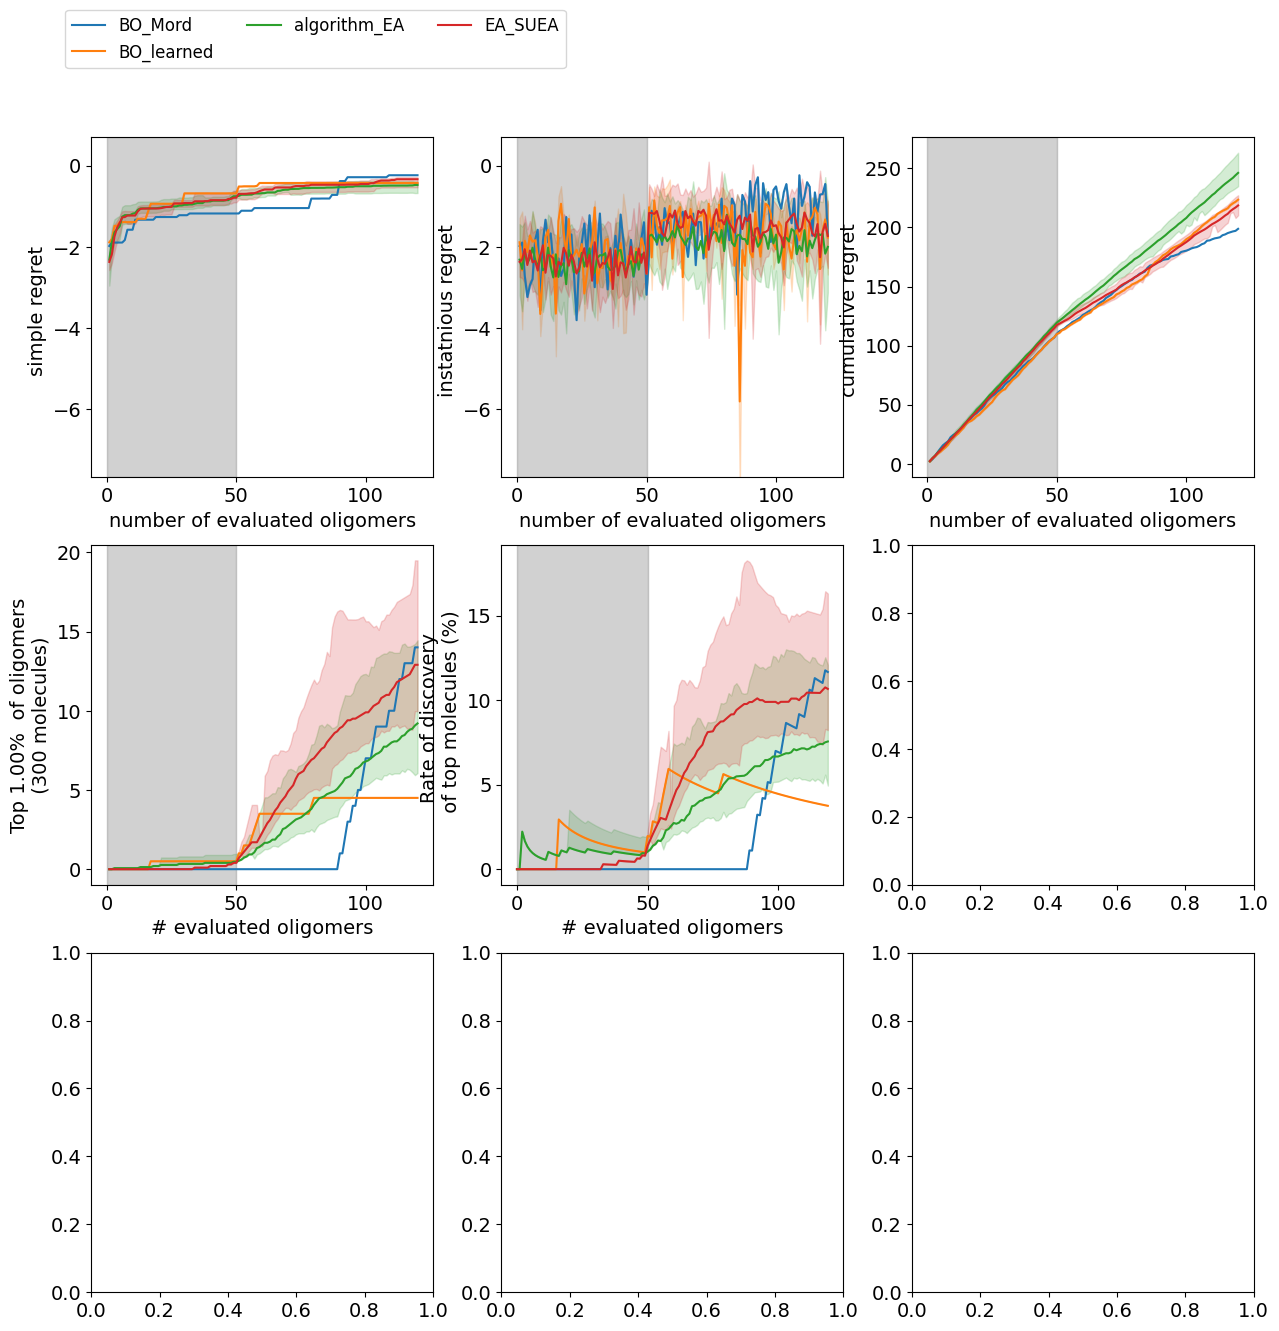

In [75]:
%matplotlib inline
df_plot = df_summary_1.copy()
df_plot = df_plot.loc[[0,1,2,3]]
fig, axes,metric_dict_res = plot_results_all.plot_metric(df_plot,plot_function_list_single,results_dict,df_list,nb_iterations=120)
fig.tight_layout
